In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys,json,os
sys.path.append('../..')
import Project.profiles as pp
import Project.new_profiles as pnp
from Project.constants import Constants as pc
import Project.quadrantHopping as qH
from tqdm.notebook import tqdm
from iminuit import Minuit
import pickle
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
class Sidm:
    def __init__(self,**kwargs):
        if 'lm' and 'rs' in kwargs.keys():
            key = 'nfw_to_iso'
            self.lm, self.rs = kwargs.get('lm'),kwargs.get('rs')
            self.ρs = pp.rho0_nfw(self.lm,self.rs)
        elif 'ρ0' and 'σ0' in kwargs.keys():
            key = 'iso_to_nfw'
            self.ρ0,self.σ0 = kwargs.get('ρ0'),kwargs.get('σ0')
        else:
            print ('Please give any one there paris: (lm,rs),(ρ0,σ0)')
    
        self.lmstar = kwargs.get('lmstar') if 'lmstar' in kwargs.keys() else 0
        self.rdstar = kwargs.get('rdstar') if 'rdstar' in kwargs.keys() else 1
        self.Σ0star = 10**(self.lmstar)/(2*np.pi*self.rdstar**2) if self.lmstar else 0
        
        self.tage = kwargs.get('tage') if 'tage' in kwargs.keys() else 10.
        self.σbym = kwargs.get('σbym') if 'σbym' in kwargs.keys() else 3.
        self.unit = 1e-10 * pc.Gyr * pc.yr * 1e3 * pc.M_sun / pc.kpc**3
        self.r = np.logspace(-2,3,400)
        
        if key == 'nfw_to_iso': self.iso_from_nfw()
        elif key == 'iso_to_nfw': self.nfw_from_iso()
        
        
    def ρ_bary(self,r):
        return self.Σ0star*np.exp(-r/self.rdstar)/(2*r)
    
    def ρ_nfw(self,r,**kwargs):
        ρs = kwargs.get('ρs') if 'ρs' in kwargs.keys() else self.ρs
        rs = kwargs.get('rs') if 'rs' in kwargs.keys() else self.rs
        return ρs/((r/rs)*(1 + (r/rs))**2)
    
    def ρ_iso(self,r,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        Φf = kwargs.get('Φf') if 'Φf' in kwargs.keys() else self.Φf
        return ρ0*np.exp(-Φf(r)/σ0**2)
    
    def ρ_kap(self,r):
        single = False
        if isinstance(r,(float,int)): r,single = [r],True
        ρ = np.zeros(len(r))
        for i in range(len(r)):
            if r[i] < self.r1: ρ[i] = self.ρ_iso(r[i])
            else: ρ[i] = self.ρ_nfw(r[i])
        if single: return ρ[0]
        else: return ρ
    
    def M_nfw(self,r,**kwargs):
        ρs = kwargs.get('ρs') if 'ρs' in kwargs.keys() else self.ρs
        rs = kwargs.get('rs') if 'rs' in kwargs.keys() else self.rs
        return 4*np.pi*ρs*(rs**3)*(np.log((r+rs)/rs) - (r/(r+rs)))
        
    def M_iso(self,r,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        Φf = kwargs.get('Φf') if 'Φf' in kwargs.keys() else self.Φf
        single = False
        if isinstance(r, (float,int)): r,single = [r],True
        M = np.zeros(len(r))
        for i in range(len(r)):
            r_ = np.logspace(-2,np.log10(r[i]),400)
            M[i] = 4*np.pi*np.trapz(self.ρ_iso(r_,ρ0 = ρ0,σ0 = σ0,Φf = Φf)*r_**2,r_)
        if single: return M[0]
        else: return M
    
    def M_kap(self,r):
        single = False
        if isinstance(r,(float,int)): r,single = [r],True
        M = np.zeros(len(r))
        for i in range(len(r)):
            if r[i] < self.r1: M[i] = self.M_iso(r[i])
            else: M[i] = self.M_nfw(r[i])
        if single: return M[0]
        else: return M
    
    def Φ_tot(self,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        def f(u,r):
            k1 = 4*np.pi*pc.G
            k2 = 4*np.pi*pc.G*ρ0
            t1 = k1*(self.ρ_bary(r))
            t2 = 2*u[1]/r
            t3 = k2*np.exp(-u[0]/σ0**2)
            return (u[1],t1-t2+t3)
        us = sp.integrate.odeint(f,[0,0],self.r)
        return us[:,0]
    
        
    def get_r1(self,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        Φf = kwargs.get('Φf') if 'Φf' in kwargs.keys() else self.Φf
        ρ1 = np.sqrt(np.pi)/(self.tage*self.σbym*4*σ0) / self.unit
        def solve_r1(lr1):
            r1 = 10**lr1
            return np.abs(np.log10(self.ρ_iso(r1,ρ0=ρ0,σ0=σ0,Φf=Φf))-np.log10(ρ1))/np.log10(ρ1)
        m_r1 = Minuit(solve_r1,lr1 = 1)
        m_r1.limits['lr1'] = (-1,np.log10(200))
        m_r1.errordef = Minuit.LIKELIHOOD
        min_res,m_r1 = qH.quadhop(m_r1,['lr1'],[1])
        return 10**min_res['globalmin'][0]
    
    def nfw_from_iso(self):
        self.Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(),kind = 'cubic', fill_value = 'extrapolate')
        self.r1 = self.get_r1()
        self.ρ1 = self.ρ_iso(self.r1)
        self.M1 = self.M_iso(self.r1)
        ρs_func = lambda rs_: self.ρ1 * (self.r1/rs_) * (1+(self.r1/rs_))**2
        def solve_rs(x):
            return np.abs(np.log10(self.M_nfw(ρs = ρs_func(x),rs=x,r=self.r1)) - np.log10(self.M1))/np.log10(self.M1)
        m_rs = Minuit(solve_rs,x = 1)
        m_rs.limits['x'] = (0.1,200)
        m_rs.errordef = Minuit.LIKELIHOOD
        min_res,m = qH.quadhop(m_rs,['x'],[1])
        self.min_res = min_res
        self.rs = min_res['globalmin'][0]
        self.ρs = ρs_func(self.rs)
        def solve_lm(x):
            r200 = pp.r200_nfw(x)
            m200 = self.M_nfw(r200)
            return np.abs(np.log10(m200)-np.log10(pp.mass_nfw(x,self.rs,r200)))/np.log10(m200)
        m_lm = Minuit(solve_lm,x = 10)
        m_lm.limits['x'] = (7,14)
        m_lm.errordef = Minuit.LIKELIHOOD
        min_res,m = qH.quadhop(m_lm,['x'],[10])
        self.lm = min_res['globalmin'][0]
        
    def check_1(self,r1,ρ0,σ0,Φf):
        rm = self.r[self.r < r1][-3]
        ρ__iso = self.ρ_iso(rm,ρ0=ρ0,σ0=σ0,Φf=Φf)
        ρ__nfw = self.ρ_nfw(rm)
        if ρ__iso < ρ__nfw: return False
        else: return True      
    
    def check_sol(self,minima):
        ρ0,σ0 = 10**minima[0],10**minima[1]
        Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(ρ0=ρ0,σ0=σ0),kind='cubic',fill_value='extrapolate')
        r1 = self.get_r1(ρ0=ρ0,σ0=σ0,Φf=Φf)
        rm = self.r[self.r < r1][-5]
        if self.ρ_nfw(rm) < self.ρ_iso(rm,ρ0=ρ0,σ0=σ0,Φf=Φf): return True
        else: return False
        
    def iso_from_nfw(self):
        def solve_iso(lρ0,lσ0):
            ρ0 = 10**lρ0
            σ0 = 10**lσ0
            Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(ρ0=ρ0,σ0=σ0),kind='cubic',fill_value='extrapolate')
            r1 = self.get_r1(ρ0=ρ0,σ0=σ0,Φf=Φf)
            M1_nfw = self.M_nfw(r1)
            M1_iso = self.M_iso(r1,ρ0=ρ0,σ0=σ0,Φf=Φf)
            ρ1_nfw = self.ρ_nfw(r1)
            ρ1_iso = self.ρ_iso(r1,ρ0=ρ0,σ0=σ0,Φf=Φf)
            return np.abs(np.log10(M1_nfw)-np.log10(M1_iso))/np.log10(M1_nfw) + np.abs(np.log10(ρ1_nfw)-np.log10(ρ1_iso))/np.log10(ρ1_nfw)
        tol,etol = 1e-5,1
        guess = [7,2]
        cnt = 0
        while etol > tol:
            cnt += 1
            m = Minuit(solve_iso,lρ0=guess[0],lσ0=guess[1])
            m.limits['lρ0'] = [np.log10(5e6),9]
            m.limits['lσ0'] = [1,np.log10(500)]
            m.errordef = Minuit.LIKELIHOOD
            min_res,m = qH.quadhop(m,['lρ0','lσ0'],guess)
            guess = min_res['globalmin']
            etol = min_res['globalfun']
            if not cnt%3:
                tol *= 10
                
        min_res['cnt'] = cnt
        self.min_res = min_res
        self.ρ0 = 10**min_res['globalmin'][0]
        self.σ0 = 10**min_res['globalmin'][1]
        self.Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(),kind='cubic',fill_value='extrapolate')
        self.r1 = self.get_r1()
        self.ρ1 = self.ρ_nfw(self.r1)
        self.M1 = self.M_nfw(self.r1)
        
    def print_results(self,full = False):
        print ('logρ0 = %.2f'%np.log10(self.ρ0))
        print ('σ_v0  = %.2f'%self.σ0)
        print ('r1    = %.2f'%self.r1)
        print ('rs    = %.2f'%self.rs)
        print ('lM200 = %.2f'%self.lm)
        print ('r200  = %.2f'%(pp.r200_nfw(self.lm)))
        if full:
            print ('logρs = %.2f'%np.log10(self.ρs))
            print ('σ/m   = %.2f'%self.σbym)
            print ('logM1 = %.2f'%np.log10(self.M1))
            print ('logρ1 = %.2f'%np.log10(self.ρ1))
            print ('logM_s= %.2f'%self.lmstar)
            print ('Rd_s  = %.2f'%self.rdstar)
            lsig = np.log10(self.Σ0star) if self.Σ0star else 0
            print ('logΣ0 = %.2f'%lsig)
            
    def v_nfw(self,r):
        return np.sqrt(pc.G*self.M_nfw(r)/r)
    
    def v_kap(self,r):
        return np.sqrt(pc.G*self.M_kap(r)/r)
            
    def plot_density(self,label = '', c = 'k',ax = None):
        if not ax:
            fig,ax = plt.subplots()
        ax.plot(self.r,self.ρ_kap(self.r), c = c, label = 'SIDM_%s'%label)
        ax.plot(self.r,self.ρ_nfw(self.r), c = c, label = 'NFW_%s'%label, ls = '--')
        ax.scatter(self.r1,self.ρ1, c = c, marker = '.', s = 200)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.legend()
        return ax
        
    def plot_velocity(self,label = '',c = 'k',ax = None):
        if not ax:
            fig,ax = plt.subplots()
        ax.plot(self.r,self.v_kap(self.r),c = c, label = 'SIDM_%s'%label)
        ax.plot(self.r,self.v_nfw(self.r),c = c, label = 'NFW_%s'%label, ls = '--')
        ax.scatter(self.r1,self.v_kap(self.r1),c = c, marker = '.', s = 200)
        ax.set_xlim(0,100)
        ax.legend()
        return ax

In [3]:
LM = np.linspace(9.,13.,9)
LS = pnp.lmstar_behroozi_19(LM)
C2 = 10**pp.lc200_SR(LM)
RD = 10**(0.28*LS - 2.40)

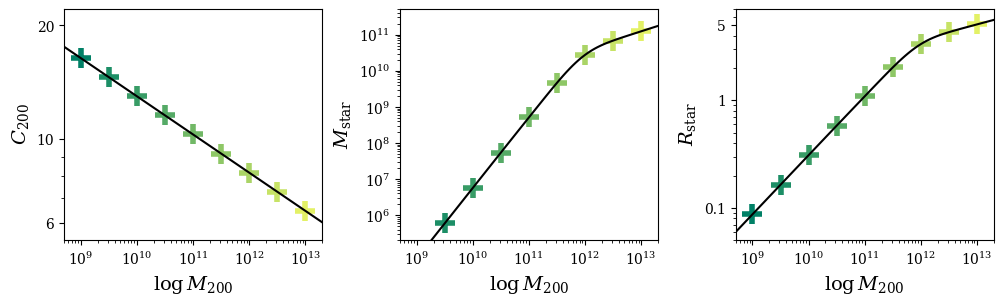

In [4]:
fig,axs = plt.subplots(1,3,figsize = (12,3), gridspec_kw = {'wspace':0.3})
ax1,ax2,ax3 = axs
cmap = 'summer'
lm = np.linspace(8.,13.5,100)
ax1.plot(10**lm,10**pp.lc200_SR(lm),c = 'k')
ax2.plot(10**lm,10**pnp.lmstar_behroozi_19(lm), c = 'k')
ax3.plot(10**lm,10**(0.28*pnp.lmstar_behroozi_19(lm)-2.4), c = 'k')

for i in range(9):
    ax1.scatter(10**LM[i],10**np.log10(C2[i]),marker = '+', s = 200, lw = 4, 
                color = plt.get_cmap(cmap)(i/9.))
    ax2.scatter(10**LM[i],10**LS[i],marker = '+', s = 200,lw = 4,
                color = plt.get_cmap(cmap)(i/9.))
    ax3.scatter(10**LM[i],10**np.log10(RD[i]),marker = '+', s = 200, lw = 4, 
                color = plt.get_cmap(cmap)(i/9.))

ax1.set_ylabel('$\,C_{200}$',size = 14)
ax2.set_ylabel('$\,M_{\mathrm{star}}$',size = 14)
ax3.set_ylabel('$\,R_{\mathrm{star}}$',size = 14)

for ax in axs:
    ax.set_xlabel('$\mathrm{log}\,M_{200}$',size = 14)
    ax.set_xscale('log')
    ax.set_xlim(5e8,2e13)
    ax.set_yscale('log')
    
ax1.set_yticks([6,10,20])
ax1.set_yticklabels([6,10,20])
ax2.set_yticks([1e6,1e7,1e8,1e9,1e10,1e11])
ax2.set_ylim(2e5,5e11)
ax3.set_yticks([0.1,1,5])
ax3.set_yticklabels([0.1,1,5])
ax3.set_ylim(5e-2,7)

plt.savefig('../Output/figures/comparison/mcr_shm_rd.pdf',bbox_inches = 'tight',dpi = 300)

In [5]:
# sidms = [[] for i in range(9)]

In [38]:
i = 8
s = Sidm(lm = LM[i], rs = pp.r200_nfw(LM[i])/C2[i], lmstar = LS[i], rdstar = RD[i])
S = Sidm(ρ0 = s.ρ0, σ0 = s.σ0, lmstar = s.lmstar, rdstar = s.rdstar)
sidms[i] =  [s,S]

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

In [39]:
s.min_res

       cnt: 1
     count: [3, 2, 4, 1]
       fun: [0.0024878641063396222, 0.0060135235998991544, 6.103100497917329e-08, 0.003557310899283609]
 globalfun: 6.103100497917329e-08
 globalmin: array([7.59082078, 2.37564553])
   message: 'At least one minima was found a sufficient number of times.'
    minima: array([[8.99999253, 2.43365361],
       [8.17436147, 2.42249825],
       [7.59082078, 2.37564553],
       [7.81691965, 2.39643384]])
 precision: 'At some point a termination due to precision loss occured.'
   success: True

<AxesSubplot: >

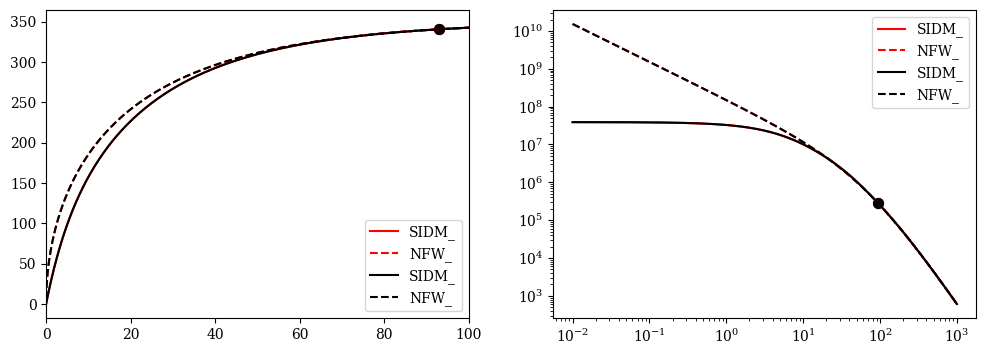

In [40]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs
s.plot_velocity(ax = ax1, c = 'r')
S.plot_velocity(ax = ax1, c = 'k')
ax1.set_xlim(0,100)
s.plot_density(ax = ax2, c = 'r')
S.plot_density(ax = ax2, c = 'k')

In [41]:
s.print_results()

logρ0 = 7.59
σ_v0  = 237.49
r1    = 92.95
rs    = 67.39
lM200 = 13.00
r200  = 435.78


In [53]:
with open('../Output/data/SIDM_9RCs.pkl', 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(sidms, outp, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('../Output/data/SIDM_9RCs.pkl','rb') as inp:
    sidms = pickle.load(inp)

In [6]:
def rs_nfw(lm,c2):
    r200 = pp.r200_nfw(lm)
    return r200/c2

def get_core_params(r,v,p0 = None,upp_bounds = [14,np.inf,np.inf],flag = None):
    def core_func(r,lm,rs,rc):
        vbnfw = pp.v_sidm(lm,rs,rc,r)
        if np.abs(vbnfw[-1]-v[-1])/v[-1] > 1:
            return vbnfw
        else:
            return vbnfw
    popt,pcov = sp.optimize.curve_fit(core_func,r,v,p0 = p0,bounds = ([8,0.1,0.1],upp_bounds))
    return popt

def temp_get_core_params(r,v,p0 = None,upp_bounds = [14,np.inf,np.inf],flag = None):
    core_func = lambda r,lm,rs,rc: pp.v_sidm(lm,rs,rc,r)
    if flag == 7:
        RS = rs_nfw(LM[7],C2[7])
        Core_func = lambda r,rc: core_func(r,12.5, RS,rc)
        popt,pcov = sp.optimize.curve_fit(Core_func,r,v,p0 = p0[2:3],bounds = ([0.1],upp_bounds[2:3]))
        popt = [12.5,RS,popt[0]]
    elif flag == 8:
        RS = rs_nfw(LM[8],C2[8])
        Core_func = lambda r,rc: core_func(r,13., RS, rc)
        popt,pcov = sp.optimize.curve_fit(Core_func,r,v,p0 = p0[2:3],bounds = ([0.1],upp_bounds[2:3]))
        popt = [13.,RS,popt[0]]
    else:
        popt,pcov = sp.optimize.curve_fit(core_func,r,v,p0 = p0,bounds = ([8,0.1,0.1],upp_bounds))
    return popt

def get_Core_params(r,v):
    rs_core = lambda lm,c2: pp.r200_nfw(lm)/c2
    def min_func(lm,lc2,lrc):
        rc = 10**lrc
        lc2_mean = pp.lc200_SR(lm)
        rs = rs_core(lm,10**lc2)
        vmodel = pp.v_sidm(lm,rs,rc,r)
        chisq = (((v-vmodel))**2).sum()
        mc = ((lc2 - lc2_mean)/0.11)**2
        return chisq + mc
    m = Minuit(min_func,lm = 9., lc2 = 1, lrc = 1)
    m.limits['lm'] =( 8.,14.)
    m.limits['lc2'] = (0,2)
    m.limits['lrc'] = (-1,np.log10(200))
    m.errordef = Minuit.LIKELIHOOD
    min_res,m = qH.quadhop(m, ['lm','lc2','lrc'],[9.,1.,1.])
    res = min_res['globalmin']
    return res[0],rs_core(res[0],10**res[1]),10**res[2],min_res

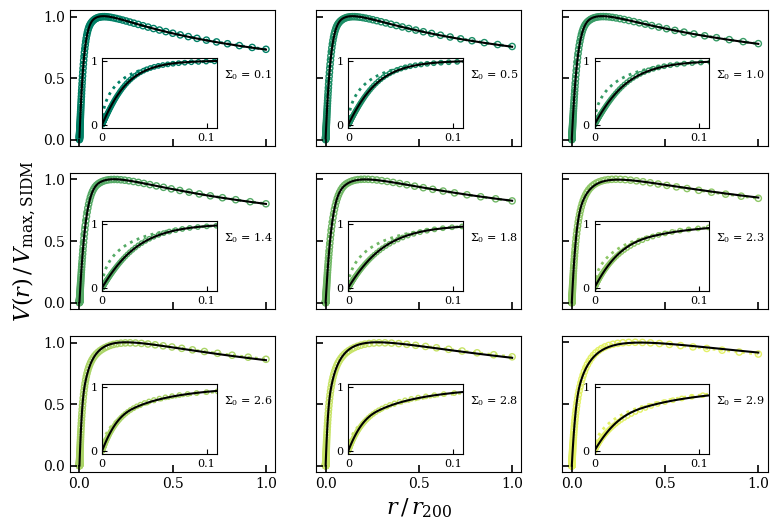

In [12]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'summer'
CP_vels = []
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    s,S = sidms[i]
    r200 = pp.r200_nfw(lm)
    rs = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    vsidm = s.v_kap(r)
    vscale = np.max(vsidm)
    cp = get_core_params(r,vsidm,[9,1,1],[14.,np.inf,10*rs],flag = i)
    # cp = get_Core_params(vsidm,r)
    vnfw = pp.v_nfw(lm,rs,r)
    vbnfw = pp.v_sidm(*cp[0:3],r)
    ax.scatter(r/r200,vsidm/vscale,color = plt.get_cmap(cmap)(i/9.),marker = 'o',
               facecolor = 'none', lw = 1, s = 20)
    ax.plot(r/r200, vnfw/vscale, color = plt.get_cmap(cmap)(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200, vbnfw/vscale, color = 'k', lw = 1.5)
    if i%3:
        ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel('$V(r)\,/\,V_{\mathrm{max,SIDM}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both', direction = 'in', width = 1.2, length = 5)
    inset_ax = inset_axes(ax,
                         width = '70%',
                         height = .7,
                         bbox_to_anchor = (-0.05,-0.3,0.8,1.),bbox_transform = ax.transAxes)
    inset_ax.scatter(r/r200,vsidm/vscale,color = plt.get_cmap(cmap)(i/9.),lw = 1,
                     marker = 'o',facecolor = 'none',s = 10)
    inset_ax.plot(r/r200,vnfw/vscale,color = plt.get_cmap(cmap)(i/9.),lw = 2,ls = ':')
    inset_ax.plot(r/r200,vbnfw/vscale,color = 'k')
    inset_ax.tick_params(which = 'both', direction = 'in',labelsize = 8)
    inset_ax.set_xlim(0,0.11)
    inset_ax.set_yticks([0,1])
    inset_ax.set_yticklabels([0,1])
    inset_ax.set_xticks([0,0.1])
    inset_ax.set_xticklabels([0,0.1])
    CP_vels.append(cp.tolist())
    ax.text(0.75,0.5,'$\Sigma_0$ = %.1f'%(np.log10(pp.sig_exp(LS[i],RD[i]))-6) ,size = 8,transform = ax.transAxes)


# plt.savefig('../Output/figures/comparison/SIDM_RC.pdf',bbox_inches = 'tight',dpi = 300)

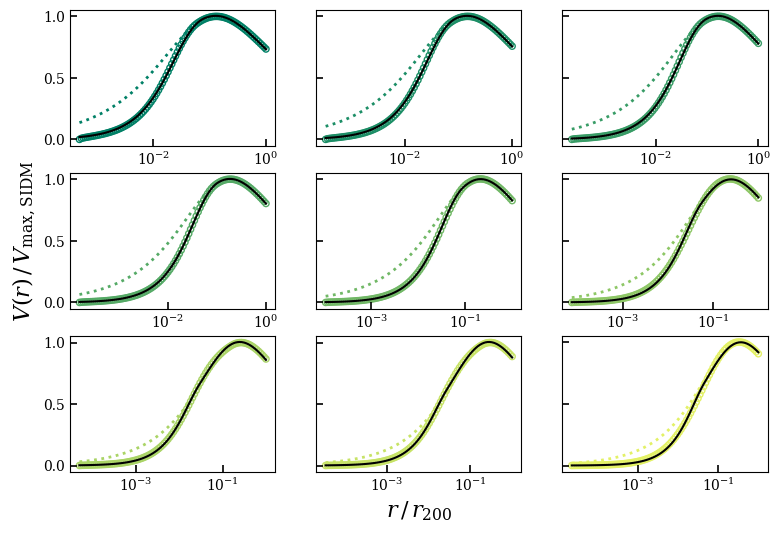

In [46]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'summer'
CP = []
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    s,S = sidms[i]
    r200 = pp.r200_nfw(lm)
    rs = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    vsidm = s.v_kap(r)
    vscale = np.max(vsidm)
    cp = get_core_params(r,vsidm,[9,1,1],[14.,np.inf,10*rs],flag = i)
    # cp = get_Core_params(vsidm,r)
    vnfw = pp.v_nfw(lm,rs,r)
    vbnfw = pp.v_sidm(*cp[0:3],r)
    ax.scatter(r/r200,vsidm/vscale,color = plt.get_cmap(cmap)(i/9.),marker = 'o',
               facecolor = 'none', lw = 1, s = 20)
    ax.plot(r/r200, vnfw/vscale, color = plt.get_cmap(cmap)(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200, vbnfw/vscale, color = 'k', lw = 1.5)
    if i%3:
        ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel('$V(r)\,/\,V_{\mathrm{max,SIDM}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both', direction = 'in', width = 1.2, length = 5)
    # inset_ax = inset_axes(ax,
    #                      width = '70%',
    #                      height = .7,
    #                      bbox_to_anchor = (0,-0.4,0.9,1.1),bbox_transform = ax.transAxes)
    # inset_ax.scatter(r/r200,vsidm/vscale,color = plt.get_cmap(cmap)(i/9.),lw = 1,
    #                  marker = 'o',facecolor = 'none',s = 10)
    # inset_ax.plot(r/r200,vnfw/vscale,color = plt.get_cmap(cmap)(i/9.),lw = 2,ls = ':')
    # inset_ax.plot(r/r200,vbnfw/vscale,color = 'k')
    # inset_ax.tick_params(which = 'both', direction = 'in',labelsize = 8)
    # inset_ax.set_xlim(0,0.11)
    # inset_ax.set_yticks([0,1])
    # inset_ax.set_yticklabels([0,1])
    # inset_ax.set_xticks([0,0.1])
    # inset_ax.set_xticklabels([0,0.1])
    CP.append(cp)
    ax.set_xscale('log')

# plt.savefig('../Output/figures/comparison/SIDM_RC.pdf',bbox_inches = 'tight',dpi = 300)

[143.4193498]
[136.91910645]
[128.01231902]
[114.50739925]
[95.41680915]
[81.38446181]
[84.93873307]
[79.8255332]
[58.69133734]


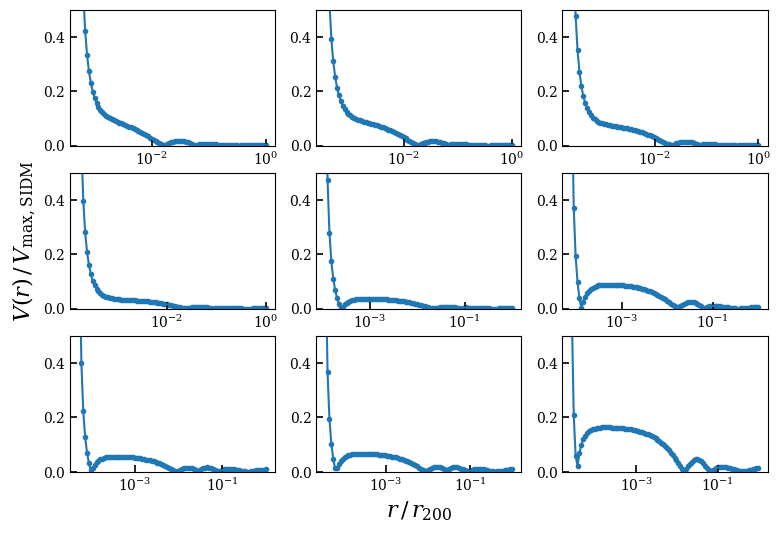

In [48]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'summer'
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    s,S = sidms[i]
    r200 = pp.r200_nfw(lm)
    rs = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    vsidm = s.v_kap(r)
    vscale = np.max(vsidm)
    cp = CP[i]
    vnfw = pp.v_nfw(lm,rs,r)
    vbnfw = pp.v_sidm(*cp[0:3],r)

    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel('$V(r)\,/\,V_{\mathrm{max,SIDM}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both', direction = 'in', width = 1.2, length = 5)
    
    indx = np.where(vsidm != 0)
    vsidm_ = vsidm[indx]
    vbnfw_ = vbnfw[indx]
    r_ = r[indx]
    diff = np.abs(vsidm_-vbnfw_)/vsidm_
    idx = np.where(diff == np.max(diff))[0]
    print (diff[idx]*100)
    ax.scatter(r_/r200,diff,marker = '.')
    ax.plot(r_/r200,diff)
    ax.set_xscale('log')
    ax.set_ylim(0,0.5)


# plt.savefig('../Output/figures/comparison/SIDM_RC.pdf',bbox_inches = 'tight',dpi = 300)

In [11]:
def get_core_params_ρ(logr,logρ,p0=None,upp_bounds = [14.,np.inf,np.inf]):
    core_func = lambda logr,lm,rs,rc: np.log10(pp.density_sidm(lm,rs,rc,10**logr))
    popt,pcov = sp.optimize.curve_fit(core_func,logr,logρ,p0=p0,bounds = ([8.,0.1,0.1],upp_bounds))
    return popt

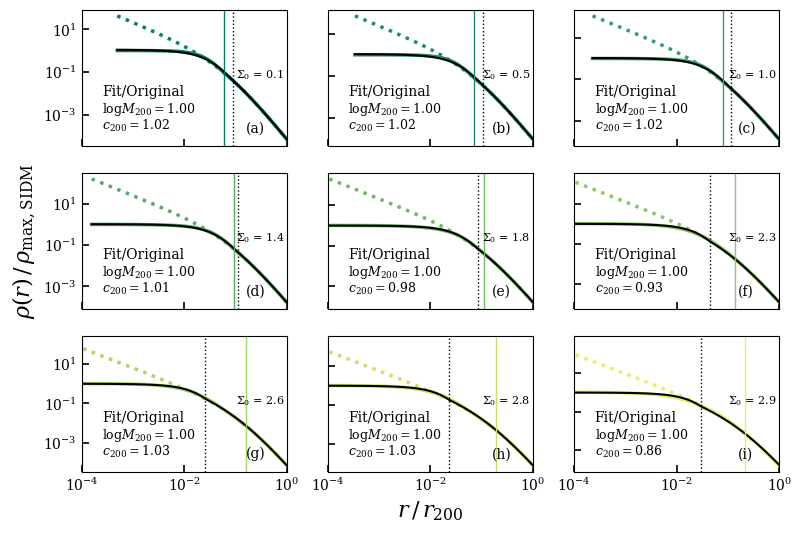

In [14]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'summer'
panels = ['a','b','c','d','e','f','g','h','i']
CP_dens = []
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    s,S = sidms[i]
    r200 = pp.r200_nfw(lm)
    rs = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    ρsidm = s.ρ_kap(r)
    ρscale = np.max(ρsidm)
    cp = get_core_params_ρ(np.log10(r),np.log10(ρsidm),[9,1,1],[14,np.inf,5*rs])
    CP_dens.append(cp.tolist())
    ρnfw = pp.density_nfw(lm,rs,r)
    ρbnfw = pp.density_sidm(*cp[0:3],r)
    
    ax.plot(r/r200, ρsidm/ρscale, color = plt.get_cmap(cmap)(i/9.), lw = 2.5)
    ax.plot(r/r200, ρnfw/ρscale, color = plt.get_cmap(cmap)(i/9.), lw = 2.5, ls = ':')
    ax.plot(r/r200, ρbnfw/ρscale, color = 'k', lw = 1.5)
    # ax.text(0.2,0.1,np.around(cp,1),transform = ax.transAxes)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-4,1e0)

    if i%3:
        ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel(r'$\rho(r)\,/\,ρ_{\mathrm{max,SIDM}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both', direction = 'in', width = 1.2, length = 5)
    ax.tick_params(which = 'both',direction = 'in', width = 1.2, length = 5)
    ax.text(0.1,0.37,'Fit/Original',size = 10, transform = ax.transAxes)
    ax.text(0.1,0.24,'$\mathrm{log}M_{200}=%.2f$'%(cp[0]/lm),size = 9, transform = ax.transAxes)
    ax.text(0.1,0.12,'$c_{200} = %.2f$'%(pp.c200_nfw(cp[0],cp[1])/c2),size = 9,transform = ax.transAxes)
    # ax.text(0.1,0.10,'$r_1 = %.1f$'%(cp[2]/s.r1),size = 8,transform = ax.transAxes)
    ax.text(0.8,0.1,'(%s)'%panels[i],size = 10, transform = ax.transAxes)
    ylim = ax.get_ylim()
    ax.plot([s.r1/r200,s.r1/r200],ylim,color = plt.get_cmap(cmap)(i/9.),ls= '-',lw = 1,alpha = 1)
    ax.plot([cp[2]/r200,cp[2]/r200],ylim,c = 'k',ls = ':',lw = 1)
    ax.set_ylim(ylim)
    ax.text(0.75,0.5,'$\Sigma_0$ = %.1f'%(np.log10(pp.sig_exp(LS[i],RD[i]))-6) ,size = 8,transform = ax.transAxes)


plt.savefig('../Output/figures/comparison/SIDM_density.pdf',bbox_inches = 'tight',dpi = 300)

In [15]:
CP = {'vels':CP_vels, 'dens':CP_dens}
json.dump(CP, open('../Output/data/SIDM_BNFW_fit.json','w'),indent = 2)

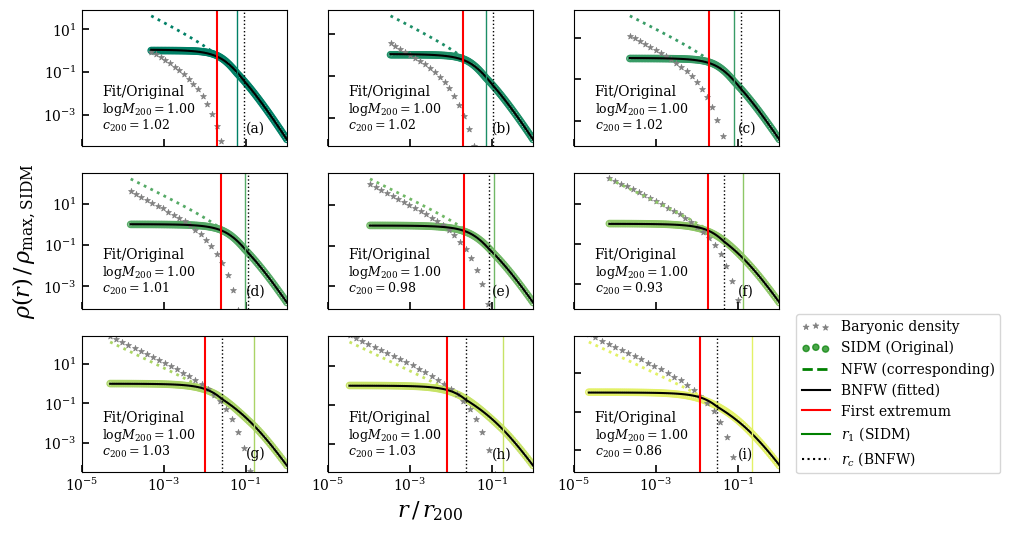

In [179]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'summer'
minimas = [2e-2,2e-2,2e-2,2.5e-2,2.1e-2,1.8e-2,1e-2,0.8e-2,1.2e-2]
CP_ρ = []
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    s,S = sidms[i]
    r200 = pp.r200_nfw(lm)
    rs = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    ρsidm = s.ρ_kap(r)
    ρscale = np.max(ρsidm)
    cp = get_core_params_ρ(np.log10(r),np.log10(ρsidm),[9,1,1],[14.,np.inf,10*rs])
    ρnfw = pp.density_nfw(lm,rs,r)
    ρbnfw = pp.density_sidm(*cp[0:3],r)
    ax.scatter(r/r200,ρsidm/ρscale,color = plt.get_cmap(cmap)(i/9.),marker = 'o',
               facecolor = 'none', lw = 1, s = 20)
    ax.plot(r/r200, ρnfw/ρscale, color = plt.get_cmap(cmap)(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200, ρbnfw/ρscale, color = 'k', lw = 1.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-5,1e0)
    if i%3:
        ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel(r'$\rho(r)\,/\,\rho_{\mathrm{max,SIDM}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both', direction = 'in', width = 1.2, length = 5)

    CP_ρ.append(cp)
    # ax.text(0.75,0.5,'$\Sigma_0$ = %.1f'%(np.log10(pp.sig_exp(LS[i],RD[i]))-6) ,size = 8,transform = ax.transAxes)
    ax.text(0.1,0.37,'Fit/Original',size = 10, transform = ax.transAxes)
    ax.text(0.1,0.24,'$\mathrm{log}M_{200}=%.2f$'%(cp[0]/lm),size = 9, transform = ax.transAxes)
    ax.text(0.1,0.12,'$c_{200} = %.2f$'%(pp.c200_nfw(cp[0],cp[1])/c2),size = 9,transform = ax.transAxes)
    # ax.text(0.1,0.10,'$r_1 = %.1f$'%(cp[2]/s.r1),size = 8,transform = ax.transAxes)
    ax.text(0.8,0.1,'(%s)'%panels[i],size = 10, transform = ax.transAxes)
    ylim = ax.get_ylim()
    ax.plot([s.r1/r200,s.r1/r200],ylim,color = plt.get_cmap(cmap)(i/9.),ls= '-',lw = 1,alpha = 1)
    ax.plot([cp[2]/r200,cp[2]/r200],ylim,c = 'k',ls = ':',lw = 1)
    ax.plot([minimas[i]]*2,ylim,c = 'r')
    newr = np.logspace(-2,np.log10(r200),30)
    ax.scatter(newr/r200,s.ρ_bary(newr)/ρscale,c = 'grey', marker = '*', s = 20, facecolor = 'none', lw = 0.5, )
    ax.set_ylim(ylim)
    # ax.set_ylim(1e-4,1e5)
    # ax.set_xlim(s.r1/r200,cp[2]/r200)
    # ax.text(0.75,0.5,'$\Sigma_0$ = %.1f'%(np.log10(pp.sig_exp(LS[i],RD[i]))-6) ,size = 8,transform = ax.transAxes)

ax = axs[8]
ax.scatter([0,0,0],[0,0,0],marker = '*', c = 'grey',s = 20, facecolor = 'none',lw =0.5, label = 'Baryonic density')
ax.scatter(0,0,marker = 'o', s = 20, color = 'g', facecolor = 'g',alpha = 0.7,lw = 1,label = 'SIDM (Original)')
ax.plot([0,0],[0,0],c = 'g', lw = 2, ls = '--',label = 'NFW (corresponding)')
ax.plot([0,0],[0,0],c = 'k',label = 'BNFW (fitted)')
ax.plot([0,0],[0,0],c = 'r',label = 'First extremum')
ax.plot([0,0],[0,0],c = 'g',label = '$r_1$ (SIDM)')
ax.plot([0,0],[0,0],c = 'k',label = '$r_c$ (BNFW)', ls = ':')
ax.legend(bbox_to_anchor = (1.05,1.21),scatterpoints = 3)



plt.savefig('../Output/figures/comparison/sidm_fit_bnfw_density_profile_2.png',bbox_inches = 'tight',dpi = 300)

[10.50042245]
[10.28908874]
[8.68267487]
[4.18413027]
[5.53752003]
[9.59681312]
[9.86634932]
[10.11921436]
[11.79481741]


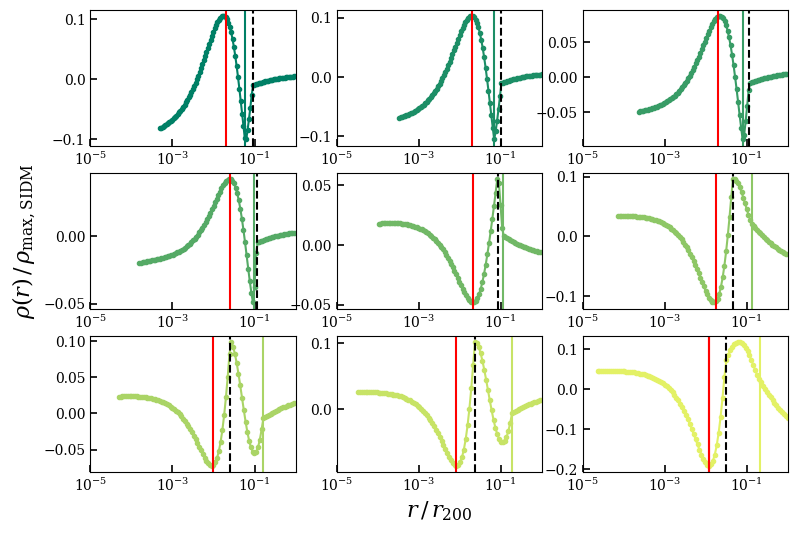

In [180]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'summer'
minimas = [2e-2,2e-2,2e-2,2.5e-2,2.1e-2,1.8e-2,1e-2,0.8e-2,1.2e-2]
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    s,S = sidms[i]
    r200 = pp.r200_nfw(lm)
    rs = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    ρsidm = s.ρ_kap(r)
    ρscale = np.max(ρsidm)
    cp = CP_ρ[i]
    ρnfw = pp.density_nfw(lm,rs,r)
    ρbnfw = pp.density_sidm(*cp[0:3],r)

    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel(r'$\rho(r)\,/\,\rho_{\mathrm{max,SIDM}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both', direction = 'in', width = 1.2, length = 5)
    
    diff = (ρsidm-ρbnfw)/ρsidm
    idx = np.where(diff == np.max(diff))[0]
    print (diff[idx]*100)
    ax.scatter(r/r200,diff,marker = '.',color = plt.get_cmap(cmap)(i/9.))
    ax.plot(r/r200,diff,color = plt.get_cmap(cmap)(i/9.))
    ax.set_xscale('log')
    # ax.set_ylim(0,0.5)
    ylim = ax.get_ylim()
    ax.plot([cp[2]/r200,cp[2]/r200],ylim,c = 'k', ls = '--')
    ax.plot([s.r1/r200,s.r1/r200],ylim,color =plt.get_cmap(cmap)(i/9.))
    ax.plot([minimas[i]]*2,ylim,c = 'r')
    ax.set_ylim(ylim)
    ax.set_xlim(1e-5,1e0)



i = 8
ylim = axs[i].get_ylim()
axs[i].plot([m[i],m[i]],ylim, c = 'r')

plt.savefig('../Output/figures/comparison/residual_sidm_fit_bnfw_density_profile_2.png',bbox_inches = 'tight',dpi = 300)